
<div style="text-align: right; direction: rtl;">
در این چالش قصد داریم با توجه به تصویری از یک صفحه شطرنج
تشخیص دهیم مجموع امتیاز مهره های کدام بازیکن بیشتر است
هر مهره شطرنج در این مساله دارای امتیازهای زیر می‌باشد  
پیاده: 1 امتیاز
اسب: 3 امتیاز
فیل: 3 امتیاز
رخ: 5 امتیاز
وزیر: 9 امتیاز
شاه: 0 امتیاز
</div>


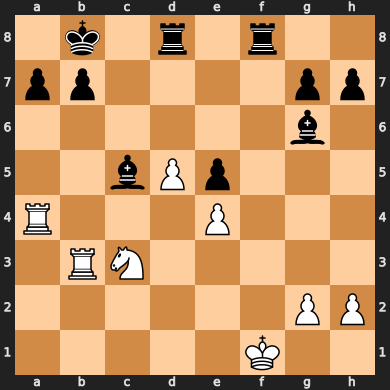

امتیاز مهره های بازیکن سیاه بیشتر می‌باشد. (سیاه: 21، سفید: 17)


In [ ]:
# !gdown --id 1-GqC5k6zv_ULXyidmDk_ol-L9qc-8k1u
# !unzip Problem02.zip

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/model_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/train.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/predict_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/vis_utils.py /content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import model_utils

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [ ]:
use_gpu

True

In [ ]:
!nvidia-smi

Thu Apr 20 12:54:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    28W /  70W |   2967MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
DATA_DIR = '/content/Problem02/'
sz = 224
batch_size = 32

In [ ]:
os.listdir(DATA_DIR)

['train', 'test']

In [ ]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [ ]:
# os.listdir(val_dir)

In [ ]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['/content/Problem02/train/0/img (2399).png',
 '/content/Problem02/train/0/img (11463).png',
 '/content/Problem02/train/0/img (5237).png',
 '/content/Problem02/train/0/img (13406).png',
 '/content/Problem02/train/0/img (9389).png']

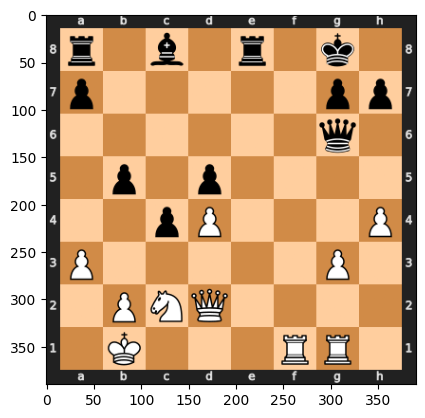

In [ ]:
img = plt.imread(trn_fnames[1])
plt.imshow(img);

In [ ]:
train_ds = datasets.ImageFolder(trn_dir)

In [ ]:
train_ds.classes


['-1', '0', '1']

In [ ]:
import cv2



import numpy as np



def adjust_contrast(image, alpha, beta):
    # Multiply each pixel value by alpha to increase contrast
    adjusted_image = np.multiply(image, alpha)
    # Add beta to each pixel value to adjust brightness
    adjusted_image = np.add(adjusted_image, beta)
    # Clip the pixel values to the range [0, 255]
    adjusted_image = np.clip(adjusted_image, 0, 255)
    adjusted_image = adjusted_image.astype(np.uint8)
    # Convert the pixel values to uint8 data type
    #adjusted_image  = cv2.cvtColor(adjusted_image, cv2.COLOR_RGB2GRAY)
    return adjusted_image

In [ ]:
class AdjustContrast(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def __call__(self, img):
        img = np.array(img)
        img = adjust_contrast(img, self.alpha, self.beta)
        img = Image.fromarray(img)
        return img

In [ ]:
!rm -R '/content/drive/MyDrive/Problem01/Problem01/Problem01/valid/ .ipynb_checkpoints'

rm: cannot remove '/content/drive/MyDrive/Problem01/Problem01/Problem01/valid/ .ipynb_checkpoints': No such file or directory


In [ ]:
tfms = transforms.Compose([
    transforms.Resize((224, 224)),  # PIL Image
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomRotation(3),
    transforms.ColorJitter(.2,.2,.3),
    transforms.ToTensor(),        # Tensor
   transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   

])


train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
#valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [ ]:
# len(train_ds)
len(train_ds)


37052

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

# valid_dl = torch.utils.data.DataLoader(valid_ds, 
#                                        batch_size=batch_size, 
#                                        shuffle=False, 
#                                        num_workers=8)


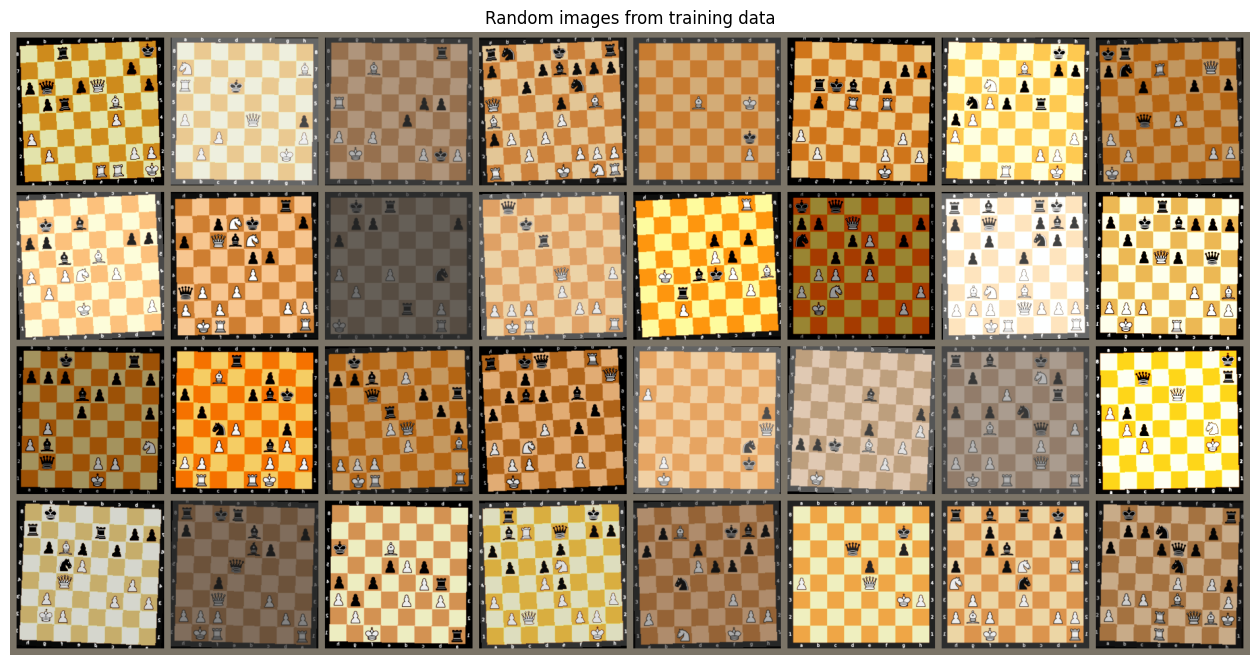

In [ ]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=10)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')


In [ ]:
Resnet50=models.resnet50(pretrained=True)
for name, param in Resnet50.named_parameters():
    if name.startswith('layer1') or name.startswith('layer2') or name.startswith('layer3'):
        param.requires_grad = True
    else:
        param.requires_grad = False

Resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
Resnet50.fc=nn.Linear(Resnet50.fc.in_features,3)
num_ftrs = Resnet50.fc.in_features
fc_layers = nn.Sequential(
                nn.Linear(num_ftrs, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Linear(256, 3),
                #nn.ReLU(inplace=True),
                #nn.Linear(128, 2)
            )
Resnet50.fc = fc_layers



print(Resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model = Resnet50

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)


In [ ]:
num_epochs = 30
losses = []

for epoch in range(num_epochs):
  
    
    for i, (inputs, targets) in enumerate(train_dl):
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))
               
            
            
            


Epoch [ 1/30], Step [ 50/1157], Loss: 0.9691


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1ea7f6790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1ea7f6790>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    Exception ignored in: 
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del_

Epoch [ 1/30], Step [100/1157], Loss: 0.9756
Epoch [ 1/30], Step [150/1157], Loss: 1.0600
Epoch [ 1/30], Step [200/1157], Loss: 0.9925
Epoch [ 1/30], Step [250/1157], Loss: 1.0256
Epoch [ 1/30], Step [300/1157], Loss: 1.0255
Epoch [ 1/30], Step [350/1157], Loss: 0.9830
Epoch [ 1/30], Step [400/1157], Loss: 1.0137
Epoch [ 1/30], Step [450/1157], Loss: 1.0065
Epoch [ 1/30], Step [500/1157], Loss: 1.0597
Epoch [ 1/30], Step [550/1157], Loss: 1.0913
Epoch [ 1/30], Step [600/1157], Loss: 0.9602
Epoch [ 1/30], Step [650/1157], Loss: 0.9862
Epoch [ 1/30], Step [700/1157], Loss: 0.8753
Epoch [ 1/30], Step [750/1157], Loss: 1.1549
Epoch [ 1/30], Step [800/1157], Loss: 0.8891
Epoch [ 1/30], Step [850/1157], Loss: 0.8131
Epoch [ 1/30], Step [900/1157], Loss: 0.7527
Epoch [ 1/30], Step [950/1157], Loss: 1.0391
Epoch [ 1/30], Step [1000/1157], Loss: 0.9041
Epoch [ 1/30], Step [1050/1157], Loss: 0.8959
Epoch [ 1/30], Step [1100/1157], Loss: 0.8825
Epoch [ 1/30], Step [1150/1157], Loss: 1.0323


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1ea7f6790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1ea7f6790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [ 2/30], Step [ 50/1157], Loss: 0.5760
Epoch [ 2/30], Step [100/1157], Loss: 0.8728
Epoch [ 2/30], Step [150/1157], Loss: 0.8823
Epoch [ 2/30], Step [200/1157], Loss: 0.7608
Epoch [ 2/30], Step [250/1157], Loss: 0.6923
Epoch [ 2/30], Step [300/1157], Loss: 0.6150
Epoch [ 2/30], Step [350/1157], Loss: 0.8687
Epoch [ 2/30], Step [400/1157], Loss: 0.7296
Epoch [ 2/30], Step [450/1157], Loss: 0.6968
Epoch [ 2/30], Step [500/1157], Loss: 0.7581
Epoch [ 2/30], Step [550/1157], Loss: 0.5696
Epoch [ 2/30], Step [600/1157], Loss: 0.6018
Epoch [ 2/30], Step [650/1157], Loss: 0.5428
Epoch [ 2/30], Step [700/1157], Loss: 0.9135
Epoch [ 2/30], Step [750/1157], Loss: 0.7642
Epoch [ 2/30], Step [800/1157], Loss: 0.6560
Epoch [ 2/30], Step [850/1157], Loss: 0.4714
Epoch [ 2/30], Step [900/1157], Loss: 0.5644
Epoch [ 2/30], Step [950/1157], Loss: 0.8848
Epoch [ 2/30], Step [1000/1157], Loss: 0.6486
Epoch [ 2/30], Step [1050/1157], Loss: 0.7405
Epoch [ 2/30], Step [1100/1157], Loss: 0.6441
Epoch [

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1ea7f6790>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1ea7f6790>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
Exception ignored in: self._shutdown_workers()
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1ea7f6790>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

        Traceback (most recent call last):
self._shutdown_workers()if w.is_alive():  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__


      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/dist-packages

Epoch [ 3/30], Step [ 50/1157], Loss: 0.6009
Epoch [ 3/30], Step [100/1157], Loss: 0.5846
Epoch [ 3/30], Step [150/1157], Loss: 0.5580
Epoch [ 3/30], Step [200/1157], Loss: 0.4405
Epoch [ 3/30], Step [250/1157], Loss: 0.6046
Epoch [ 3/30], Step [300/1157], Loss: 0.6128
Epoch [ 3/30], Step [350/1157], Loss: 0.6556
Epoch [ 3/30], Step [400/1157], Loss: 0.6377
Epoch [ 3/30], Step [450/1157], Loss: 0.6118
Epoch [ 3/30], Step [500/1157], Loss: 0.5040
Epoch [ 3/30], Step [550/1157], Loss: 0.6721
Epoch [ 3/30], Step [600/1157], Loss: 0.5202
Epoch [ 3/30], Step [650/1157], Loss: 0.7174
Epoch [ 3/30], Step [700/1157], Loss: 0.3313
Epoch [ 3/30], Step [750/1157], Loss: 0.4691
Epoch [ 3/30], Step [800/1157], Loss: 0.7285
Epoch [ 3/30], Step [850/1157], Loss: 0.5588
Epoch [ 3/30], Step [900/1157], Loss: 1.2585
Epoch [ 3/30], Step [950/1157], Loss: 0.3993
Epoch [ 3/30], Step [1000/1157], Loss: 0.6095
Epoch [ 3/30], Step [1050/1157], Loss: 0.4838
Epoch [ 3/30], Step [1100/1157], Loss: 0.4628
Epoch [

KeyboardInterrupt: ignored

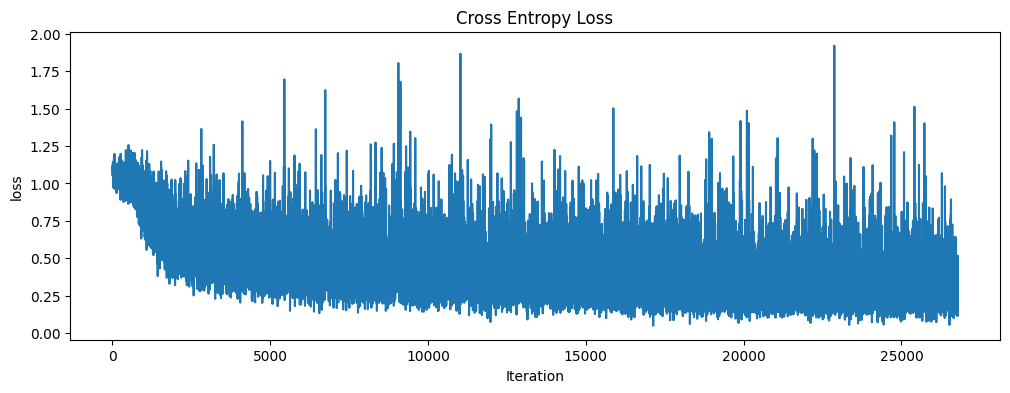

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    

In [ ]:
# evaluate_model(model, valid_dl, device)

In [ ]:
evaluate_model(model, train_dl, device)


accuracy: 89.54


In [ ]:
folder_path='/content/Problem02/test'
import os

In [ ]:
tfms = transforms.Compose([
    transforms.Resize((224, 224)),  # PIL Image

    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   

])


In [ ]:
def lab(model):
    p=[]
    for i in range(len(os.listdir(folder_path))):
  
        img_path = f'/content/Problem02/test/img{i}.png'
        img = Image.open(img_path)
        img = tfms(img)
        img = img.unsqueeze(0)

        model.eval()  # for batch normalization layers
        with torch.no_grad():
            class_names=['-1','0','1']
            inputs = img.to(device)
            outputs = model(inputs)
            _,preds = torch.max( outputs, 1)
    
            #result=preds[0]['scores'].cpu().numpy()
            result=preds.cpu().numpy()
            pred_class_names = [class_names[i] for i in result]
            p+= pred_class_names
    return p

In [ ]:
lab=lab(model)

In [ ]:
import csv

with open('predictions.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     for i in range(len(lab)) :
          writer.writerow([f"img{i}", f"{lab[i]}"])
    

In [ ]:
visualize_model(model, train_dl, device)


In [ ]:
plot_errors(model, valid_dl, device)
